In [1]:
import pandas as pd
from nba_api.stats.endpoints import leaguegamefinder
from nba_api.stats.static import teams

# Function to get box scores for a given season
def get_box_scores(season):
    game_finder = leaguegamefinder.LeagueGameFinder(season_nullable=season)
    games = game_finder.get_data_frames()[0]
    return games

nba_teams = teams.get_teams()
team_id_to_code = {team['id']: team['abbreviation'] for team in nba_teams}

# Get a list of active NBA team IDs
nba_teams = teams.get_teams()
nba_team_ids = [team['id'] for team in nba_teams]

# List to store dataframes for each season
all_seasons_dataframes = []

# Seasons to fetch data for
seasons = ['2019-20','2020-21','2021-22', '2022-23', '2023-24']

# Fetch box scores for each season
for season in seasons:
    season_data = get_box_scores(season)
    all_seasons_dataframes.append(season_data)

# Concatenate dataframes for all seasons
all_games_df = pd.concat(all_seasons_dataframes, ignore_index=True)

# Filter data for only real NBA teams
all_games_df = all_games_df[all_games_df['TEAM_ID'].isin(nba_team_ids)]

# Convert the 'GAME_DATE' column to datetime
all_games_df['GAME_DATE'] = pd.to_datetime(all_games_df['GAME_DATE'])

# Create a new column indicating home or away game
all_games_df['HOME_AWAY'] = all_games_df['MATCHUP'].apply(lambda x: 'Home' if 'vs.' in x else 'Away')

# Define aggregation functions for each column
agg_df = all_games_df.groupby(['GAME_ID', 'TEAM_ID', 'HOME_AWAY']).agg({
    'GAME_ID': 'first',  # Keep the first value of GAME_ID within each group
    'GAME_DATE': 'max',  # Aggregate game date by taking the maximum date
    'MATCHUP':'max',
    'WL' : 'first', 
    'MIN': 'sum', 
    'PTS': 'sum', 
    'FGM': 'sum', 
    'FGA': 'sum', 
    'FG_PCT': 'mean',
    'FG3M': 'sum', 
    'FG3A': 'sum', 
    'FG3_PCT': 'mean', 
    'FTM': 'sum', 
    'FTA': 'sum', 
    'FT_PCT': 'mean', 
    'OREB': 'sum', 
    'DREB': 'sum', 
    'REB': 'sum', 
    'AST': 'sum', 
    'STL': 'sum', 
    'BLK': 'sum', 
    'TOV': 'sum', 
    'PF': 'sum', 
    'PLUS_MINUS': 'sum'
})

# Flatten MultiIndex columns
agg_df.columns = ['{}_{}'.format(col[0], col[1]) for col in agg_df.columns]

# Reset index to flatten
agg_df.reset_index(inplace=True)

# Merge home and away data based on GAME_ID
merged_df = agg_df.merge(agg_df, on='GAME_ID')

# Filter out rows where the TEAM_IDs are the same (same team cannot play against itself)
merged_df = merged_df[merged_df['TEAM_ID_x'] != merged_df['TEAM_ID_y']]

# Filter out rows where HOME_AWAY_x is 'Away'
#merged_df = merged_df[merged_df['HOME_AWAY_x'] != 'Away']

# Replace 'W' with 1 and 'L' with 0 in the W_L_x column
merged_df['W_L_x'] = merged_df['W_L_x'].replace({'W': 1, 'L': 0})

merged_df = merged_df.drop(['W_L_y', 'GAME_ID','HOME_AWAY_x','HOME_AWAY_y','P_L_y', 'G_A_y', 'M_I_y', 'P_L_x','M_A_y'], axis=1)

merged_df['TEAM_ID_x'] = merged_df['TEAM_ID_x'].map(team_id_to_code)
merged_df['TEAM_ID_y'] = merged_df['TEAM_ID_y'].map(team_id_to_code)

merged_df.tail()


,TEAM_ID_x,G_A_x,G_A_x,M_A_x,W_L_x,M_I_x,P_T_x,F_G_x,F_G_x,F_G_x,...,F_T_y,F_T_y,O_R_y,D_R_y,R_E_y,A_S_y,S_T_y,B_L_y,T_O_y,P_F_y
26354,MIA,0052300201,2024-04-19,MIA vs. CHI,1.0,239,112,38,82,0.463,...,10,0.800,7,31,38,27,12,6,12,19
26357,NOP,0052300211,2024-04-19,NOP vs. SAC,1.0,240,105,44,85,0.518,...,22,0.682,14,26,40,21,9,4,15,17
26358,SAC,0052300211,2024-04-19,SAC @ NOP,0.0,240,98,36,88,0.409,...,13,0.769,11,34,45,29,9,8,15,19
26361,LAL,0062300001,2023-12-09,LAL vs. IND,1.0,242,123,47,88,0.534,...,33,0.879,9,23,32,27,10,7,9,33
26362,IND,0062300001,2023-12-09,IND @ LAL,0.0,238,109,35,95,0.368,...,35,0.771,12,43,55,25,5,10,18,25


In [2]:
merged_df.columns = ['TEAM_ID_x', 'GAME_ID', 'G_A_x', 'M_A_x', 'W_L_x', 'M_I_x', 'P_T_x',
       'F_G_x', 'F_G_x', 'F_G_x', 'F_G_x', 'F_G_x', 'F_G_x', 'F_T_x', 'F_T_x',
       'F_T_x', 'O_R_x', 'D_R_x', 'R_E_x', 'A_S_x', 'S_T_x', 'B_L_x', 'T_O_x',
       'P_F_x', 'TEAM_ID_y', 'P_T_y', 'F_G_y', 'F_G_y', 'F_G_y', 'F_G_y',
       'F_G_y', 'F_G_y', 'F_T_y', 'F_T_y', 'F_T_y', 'O_R_y', 'D_R_y', 'R_E_y',
       'A_S_y', 'S_T_y', 'B_L_y', 'T_O_y', 'P_F_y']

In [3]:
# Extract season information from game dates
def get_season(game_date):
    if game_date.month >= 10:  # NBA season typically starts in October
        return game_date.year
    else:
        return game_date.year - 1  # Season spans two calendar years

# Add season column to the DataFrame
merged_df['SEASON'] = merged_df['G_A_x'].apply(get_season)

# Display the resulting DataFrame with the season column
print(merged_df.head())

   TEAM_ID_x     GAME_ID      G_A_x        M_A_x  W_L_x  M_I_x  P_T_x  F_G_x  \
2        HOU  0011900002 2019-10-04    HOU @ LAC    1.0    239    109     33   
3        LAC  0011900002 2019-10-04  LAC vs. HOU    0.0    239     96     33   
6        IND  0011900003 2019-10-04    IND @ SAC    1.0    264    132     48   
7        SAC  0011900003 2019-10-04  SAC vs. IND    0.0    264    131     44   
11       IND  0011900005 2019-10-05  IND vs. SAC    1.0    242    130     49   

    F_G_x  F_G_x  ...  F_T_y  O_R_y  D_R_y  R_E_y  A_S_y  S_T_y  B_L_y  T_O_y  \
2      88  0.375  ...  0.600     11     38     49     26      5      8     22   
3      86  0.384  ...  0.800     12     40     52     21     11      5     20   
6      93  0.516  ...  0.778      6     24     30     30      8      4     22   
7      89  0.494  ...  0.788     14     33     47     26     11      3     24   
11     94  0.521  ...  0.780      4     31     35     24     10      7     18   

    P_F_y  SEASON  
2      35   

In [4]:
columnNames = ['TEAM_H', 'GAME_ID','GAME_DATE','MATCHUP_H', 'WL_H', 'MIN', 
               'PTS_H', 'FGM_H', 'FGA_H', 'FG_PCT_H',
               'FG3M_H', 'FG3A_H', 'FG3_PCT_H', 'FTM_H', 'FTA_H', 
               'FT_PCT_H', 'OREB_H','DREB_H','REB_H', 'AST_H', 'STL_H', 
               'BLK_H', 'TOV_H', 'PF_H', 'TEAM_A','PTS_A', 'FGM_A', 'FGA_A', 
               'FG_PCT_A', 'FG3M_A', 'FG3A_A', 'FG3_PCT_A', 'FTM_A', 'FTA_A', 
               'FT_PCT_A', 'OREB_A', 'DREB_A', 'REB_A', 'AST_A', 'STL_A', 
               'BLK_A', 'TOV_A', 'PF_A','SEASON']
merged_df.columns = columnNames


In [5]:
df = merged_df.sort_values("GAME_DATE")
df = df.reset_index(drop=True)
df.rename(columns={'WL_H': 'target'}, inplace=True)
df['home'] = df['MATCHUP_H'].str.contains('vs.').astype(int)

In [6]:
#create a duplicate df for exporting purposes
exp_df = df

In [7]:
df = df.dropna()

In [8]:
removed_columns = ["TEAM_H","GAME_ID","GAME_DATE", "TEAM_A", "target", "SEASON", "MIN","PTS_H","PTS_A","MATCHUP_H", "FGM_H", "FGM_A"] 
selected_columns = df.columns[~df.columns.isin(removed_columns)]
selected_df = df.drop(columns=removed_columns)


## EDA

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\augus\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [10]:
df.shape

(13164, 45)

In [11]:
df["target"].value_counts()


1.0    6582
0.0    6582
Name: target, dtype: int64

In [12]:
df.describe()

,target,MIN,PTS_H,FGM_H,FGA_H,FG_PCT_H,FG3M_H,FG3A_H,FG3_PCT_H,FTM_H,...,OREB_A,DREB_A,REB_A,AST_A,STL_A,BLK_A,TOV_A,PF_A,SEASON,home
count,13164.000000,13164.000000,13164.000000,13164.000000,13164.000000,13164.000000,13164.000000,13164.000000,13164.000000,13164.000000,...,13164.000000,13164.000000,13164.000000,13164.000000,13164.000000,13164.000000,13164.000000,13164.000000,13164.000000,13164.000000
mean,0.500000,241.529474,112.277119,41.137116,88.329307,0.466686,12.494834,34.767016,0.358574,17.508052,...,10.226907,33.914616,44.141522,25.014661,7.557125,4.860757,13.435810,19.867897,2021.057885,0.500000
std,0.500019,6.728335,12.626848,5.268348,7.067099,0.055376,3.885474,6.895176,0.084388,5.900979,...,3.763797,5.497633,6.668439,5.042825,2.916864,2.483460,3.978316,4.253882,1.401042,0.500019
min,0.000000,196.000000,59.000000,21.000000,63.000000,0.269000,2.000000,10.000000,0.069000,2.000000,...,0.000000,16.000000,23.000000,8.000000,0.000000,0.000000,1.000000,6.000000,2019.000000,0.000000
25%,0.000000,240.000000,104.000000,38.000000,84.000000,0.429000,10.000000,30.000000,0.302000,13.000000,...,8.000000,30.000000,39.000000,22.000000,5.000000,3.000000,11.000000,17.000000,2020.000000,0.000000
50%,0.500000,240.000000,112.000000,41.000000,88.000000,0.466000,12.000000,34.000000,0.357000,17.000000,...,10.000000,34.000000,44.000000,25.000000,7.000000,5.000000,13.000000,20.000000,2021.000000,0.500000
75%,1.000000,241.000000,121.000000,45.000000,93.000000,0.505000,15.000000,39.000000,0.415000,21.000000,...,13.000000,38.000000,48.000000,28.000000,9.000000,6.000000,16.000000,23.000000,2022.000000,1.000000
max,1.000000,316.000000,176.000000,65.000000,121.000000,0.687000,29.000000,69.000000,0.720000,44.000000,...,29.000000,60.000000,74.000000,50.000000,22.000000,20.000000,30.000000,37.000000,2023.000000,1.000000


13.435809784260103

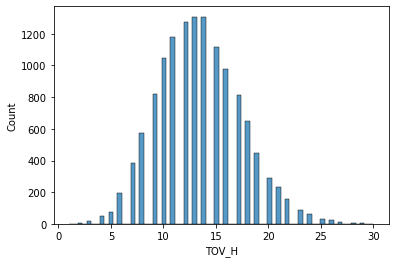

In [14]:
sns.histplot(df['TOV_H'])
df['TOV_H'].mean()

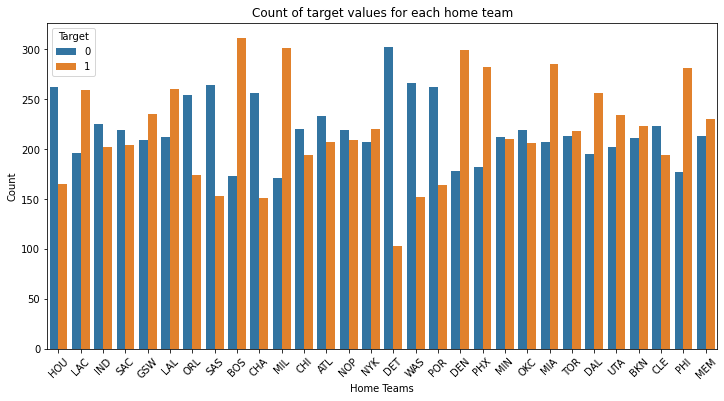

In [15]:
plt.figure(figsize=(12, 6))
sns.countplot(x='TEAM_H', hue='target', data=df)
plt.xlabel('Home Teams')
plt.ylabel('Count')
plt.title('Count of target values for each home team')
plt.xticks(rotation=45)
plt.legend(title='Target', labels=['0', '1']) # Assuming target values are 0 and 1
plt.show()

### Find Rolling Averages From All Teams

In [16]:
df_rolling = df[list(selected_columns) + ["target", "TEAM_H", "SEASON"]]

def find_team_averages(team):
    rolling = team.rolling(5).mean()
    return rolling

df_rolling = df_rolling.groupby(["TEAM_H", "SEASON"], group_keys=False).apply(find_team_averages)


C:\Users\augus\AppData\Local\Temp\ipykernel_26844\4164271589.py:4: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['TEAM_H'], dtype='object')
  rolling = team.rolling(5).mean()


In [17]:
rolling_cols = [f"{col}_5" for col in df_rolling.columns]
df_rolling.columns = rolling_cols
df = pd.concat([df, df_rolling], axis=1)

In [18]:
df = df.dropna()


In [19]:
def shift_col(team, col_name):
    next_col = team[col_name].shift(-1)
    return next_col

def add_col(df, col_name):
    return df.groupby("TEAM_H", group_keys=False).apply(lambda x: shift_col(x, col_name))

df["home_next"] = add_col(df, "home")
df["team_opp_next"] = add_col(df, "TEAM_A")
df["date_next"] = add_col(df, "GAME_DATE")
df

,TEAM_H,GAME_ID,GAME_DATE,MATCHUP_H,target,MIN,PTS_H,FGM_H,FGA_H,FG_PCT_H,...,STL_A_5,BLK_A_5,TOV_A_5,PF_A_5,home_5,target_5,SEASON_5,home_next,team_opp_next,date_next
77,ORL,0011900049,2019-10-13,ORL vs. PHI,0.0,242,94,34,87,0.391,...,10.2,4.0,22.6,20.4,0.4,0.6,2019.0,1.0,MIA,2019-10-17
98,LAL,0011900068,2019-10-16,LAL vs. GSW,1.0,241,126,49,82,0.598,...,10.4,5.4,21.2,24.2,0.6,0.6,2019.0,0.0,GSW,2019-10-18
102,CHA,0011900062,2019-10-16,CHA vs. DET,0.0,243,110,41,80,0.513,...,9.8,7.0,20.6,21.4,0.6,0.2,2019.0,1.0,CHI,2019-10-23
106,DET,0011900062,2019-10-16,DET @ CHA,1.0,241,116,42,87,0.483,...,7.4,6.2,15.0,24.0,0.6,0.6,2019.0,0.0,IND,2019-10-23
112,DAL,0011900073,2019-10-17,DAL @ LAC,1.0,240,102,35,78,0.449,...,8.8,4.8,18.6,25.0,0.4,0.4,2019.0,1.0,WAS,2019-10-23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13161,IND,0042300211,2024-05-06,IND @ NYK,0.0,240,117,46,88,0.523,...,5.6,2.8,11.2,19.2,0.6,0.6,2023.0,NaN,NaN,NaT
13162,MIN,0042300232,2024-05-06,MIN @ DEN,1.0,239,106,42,84,0.500,...,7.8,3.8,13.4,21.2,0.2,1.0,2023.0,NaN,NaN,NaT
13163,DEN,0042300232,2024-05-06,DEN vs. MIN,0.0,238,80,29,83,0.349,...,7.2,5.6,10.4,17.6,0.6,0.4,2023.0,NaN,NaN,NaT
13164,BOS,0042300201,2024-05-07,BOS vs. CLE,1.0,240,120,45,92,0.489,...,4.2,1.8,9.6,17.8,0.6,0.8,2023.0,NaN,NaN,NaT


In [20]:
full = df.merge(df[rolling_cols + ["team_opp_next", "date_next", "TEAM_H"]], left_on=["TEAM_H", "date_next"], right_on=["team_opp_next", "date_next"])
full

,TEAM_H_x,GAME_ID,GAME_DATE,MATCHUP_H,target,MIN,PTS_H,FGM_H,FGA_H,FG_PCT_H,...,AST_A_5_y,STL_A_5_y,BLK_A_5_y,TOV_A_5_y,PF_A_5_y,home_5_y,target_5_y,SEASON_5_y,team_opp_next_y,TEAM_H_y
0,CHA,0011900062,2019-10-16,CHA vs. DET,0.0,243,110,41,80,0.513,...,28.0,8.6,6.0,21.0,20.4,0.6,0.4,2019.0,CHA,CHI
1,CHI,0011900070,2019-10-17,CHI vs. ATL,1.0,242,111,41,93,0.441,...,24.0,9.8,7.0,20.6,21.4,0.6,0.2,2019.0,CHI,CHA
2,ATL,0011900070,2019-10-17,ATL @ CHI,0.0,240,93,33,79,0.418,...,22.6,7.4,6.4,15.6,24.8,0.4,0.8,2019.0,ATL,DET
3,MIL,0011900071,2019-10-17,MIL vs. MIN,1.0,238,118,43,84,0.512,...,27.0,11.0,5.2,21.2,27.6,0.4,0.6,2019.0,MIL,HOU
4,HOU,0011900076,2019-10-18,HOU @ MIA,1.0,240,144,45,86,0.523,...,21.2,10.0,3.0,18.4,23.2,0.4,1.0,2019.0,HOU,MIL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12461,ORL,0042300136,2024-05-03,ORL vs. CLE,1.0,240,103,35,89,0.393,...,20.4,6.6,5.0,13.6,18.8,0.4,0.4,2023.0,ORL,CLE
12462,CLE,0042300136,2024-05-03,CLE @ ORL,0.0,239,96,42,86,0.488,...,20.8,8.0,6.0,13.4,21.6,0.6,0.6,2023.0,CLE,ORL
12463,MIN,0042300231,2024-05-04,MIN @ DEN,1.0,239,106,43,82,0.524,...,24.8,6.2,3.8,10.8,17.6,0.6,0.6,2023.0,MIN,DEN
12464,DEN,0042300231,2024-05-04,DEN vs. MIN,0.0,240,99,35,75,0.467,...,20.6,8.4,3.8,13.2,22.2,0.4,1.0,2023.0,DEN,MIN


In [21]:
full[["TEAM_H_x", "team_opp_next_x", "TEAM_H_y", "team_opp_next_y", "date_next"]]

,TEAM_H_x,team_opp_next_x,TEAM_H_y,team_opp_next_y,date_next
0,CHA,CHI,CHI,CHA,2019-10-23
1,CHI,CHA,CHA,CHI,2019-10-23
2,ATL,DET,DET,ATL,2019-10-24
3,MIL,HOU,HOU,MIL,2019-10-24
4,HOU,MIL,MIL,HOU,2019-10-24
...,...,...,...,...,...
12461,ORL,CLE,CLE,ORL,2024-05-05
12462,CLE,ORL,ORL,CLE,2024-05-05
12463,MIN,DEN,DEN,MIN,2024-05-06
12464,DEN,MIN,MIN,DEN,2024-05-06


In [22]:
datetime_columns = list(df.select_dtypes(include=['datetime']).columns)

removed_columns_full = list(full.columns[full.dtypes == "object"]) + removed_columns + datetime_columns + list(df.columns)
removed_columns_full.append('target_5_x')

### EDA Extended

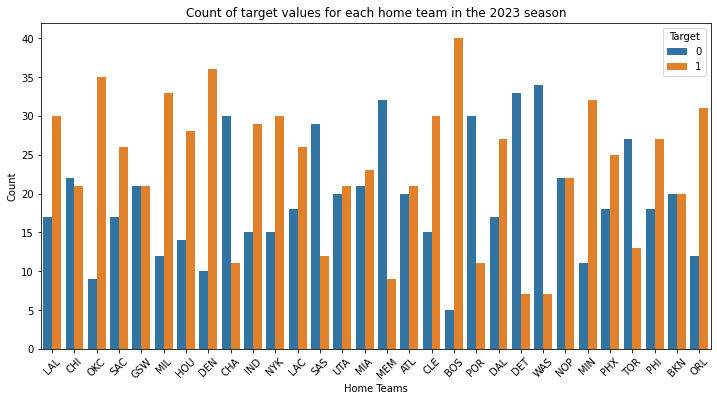

In [23]:
df_2023 = df[df['SEASON'] == 2023]
df_2023 = df_2023[df_2023['home']==1]
# Plotting count plot
plt.figure(figsize=(12, 6))
sns.countplot(x='TEAM_H', hue='target', data=df_2023)
plt.xlabel('Home Teams')
plt.ylabel('Count')
plt.title('Count of target values for each home team in the 2023 season')
plt.xticks(rotation=45)
plt.legend(title='Target', labels=['0', '1']) # Assuming target values are 0 and 1
plt.show()

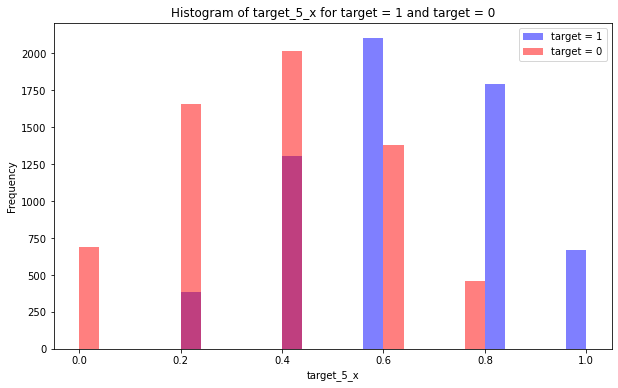

In [24]:
target_1_data = full[full['target'] == 1]['target_5_x']

# Filter data where 'target' = 0
target_0_data = full[full['target'] == 0]['target_5_x']

# Plotting histograms
plt.figure(figsize=(10, 6))

plt.hist(target_1_data, bins=20, alpha=0.5, color='blue', label='target = 1')
plt.hist(target_0_data, bins=20, alpha=0.5, color='red', label='target = 0')

plt.xlabel('target_5_x')
plt.ylabel('Frequency')
plt.title('Histogram of target_5_x for target = 1 and target = 0')
plt.legend()

plt.show()

### Test Model with Newly Refined Data

#### Ridge

In [25]:
from sklearn.linear_model import RidgeClassifier
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

def backtest(data, model, predictors, start=3, step=1):
    all_predictions = []
    
    seasons = sorted(data["SEASON"].unique())
    
    for i in range(start, len(seasons), step):
        season = seasons[i]
        train = data[data["SEASON"] < season]
        test = data[data["SEASON"] == season]
        
        model.fit(train[predictors], train["target"])
        
        preds = model.predict(test[predictors])
        preds = pd.Series(preds, index=test.index)
        combined = pd.concat([test["target"], preds], axis=1)
        combined.columns = ["actual", "prediction"]
        
        all_predictions.append(combined)
    return pd.concat(all_predictions)

# Define RidgeClassifier with Pipeline
rr = RidgeClassifier()
scaler = MinMaxScaler()
sfs = SequentialFeatureSelector(estimator=rr, direction="forward", n_jobs=1)
pipe = Pipeline([
    ('scaler', scaler),
    ('sfs', sfs),
    ('classifier', rr)
])

# Define parameter grid for GridSearchCV
param_grid = {
    'sfs__estimator__alpha': [0.1, 1, 10],  
    'sfs__n_features_to_select': [10, 20, 30],  
}

# Perform GridSearchCV
grid_search = GridSearchCV(pipe, param_grid, cv=TimeSeriesSplit(n_splits=3))

selected_columns = full.columns[~full.columns.isin(removed_columns_full)]
full[selected_columns] = scaler.fit_transform(full[selected_columns])

# Fit GridSearchCV
grid_search.fit(full[selected_columns], full['target'])

# Extract best estimator from grid search
best_estimator = grid_search.best_estimator_

selected_columns = full.columns[~full.columns.isin(removed_columns_full)]
predictions = backtest(full, best_estimator, selected_columns)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('sfs',
                 SequentialFeatureSelector(estimator=RidgeClassifier(alpha=1),
                                           n_features_to_select=30, n_jobs=1)),
                ('classifier', RidgeClassifier())])

In [26]:
pipe.named_steps['sfs'].fit(full[selected_columns], full['target']) 
pipe.named_steps['classifier'].fit(full[selected_columns], full['target'])  


selected_predictors_mask = pipe.named_steps['sfs'].get_support()
selected_predictors = selected_columns[selected_predictors_mask]


C:\Users\augus\anaconda3\lib\site-packages\sklearn\feature_selection\_sequential.py:188: FutureWarning: Leaving `n_features_to_select` to None is deprecated in 1.0 and will become 'auto' in 1.3. To keep the same behaviour as with None (i.e. select half of the features) and avoid this warning, you should manually set `n_features_to_select='auto'` and set tol=None when creating an instance.
  warnings.warn(


In [27]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, f1_score

accuracy_score(predictions["actual"], predictions["prediction"])


0.6713016608729239

In [28]:
confusion_matrix(predictions["actual"], predictions["prediction"])


array([[1723,  858],
       [ 844, 1753]], dtype=int64)

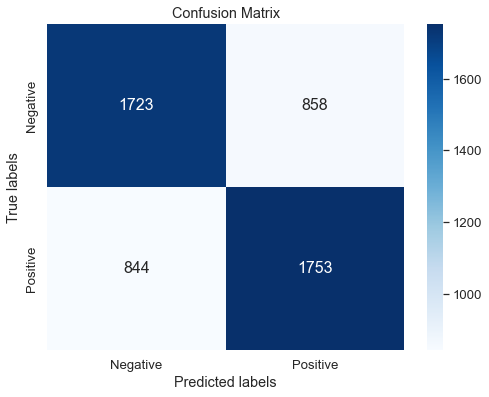

In [29]:
# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size
sns.heatmap(confusion_matrix(predictions["actual"], predictions["prediction"])
, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})

# Adding labels, title, and ticks
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.xticks([0.5, 1.5], ['Negative', 'Positive'])
plt.yticks([0.5, 1.5], ['Negative', 'Positive'])
plt.show()

In [30]:
f1_score(predictions["actual"], predictions["prediction"])


0.673195084485407

In [31]:
print(classification_report(predictions["actual"], predictions["prediction"]))

              precision    recall  f1-score   support

         0.0       0.67      0.67      0.67      2581
         1.0       0.67      0.68      0.67      2597

    accuracy                           0.67      5178
   macro avg       0.67      0.67      0.67      5178
weighted avg       0.67      0.67      0.67      5178



### Data Export

Exporting Previous Data

In [32]:
#df_export = full.iloc[7288:]
df_export = full.iloc[7288:]

In [33]:
df_export.loc[:, 'predictions'] = predictions['prediction']

C:\Users\augus\AppData\Local\Temp\ipykernel_26844\1571616758.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_export.loc[:, 'predictions'] = predictions['prediction']


In [34]:
df_export['target'] = df_export['target'].replace({1: 'Win', 0: 'Loss'})
df_export['predictions'] = df_export['predictions'].replace({1: 'Win', 0: 'Loss'})


C:\Users\augus\AppData\Local\Temp\ipykernel_26844\1536686530.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_export['target'] = df_export['target'].replace({1: 'Win', 0: 'Loss'})
C:\Users\augus\AppData\Local\Temp\ipykernel_26844\1536686530.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_export['predictions'] = df_export['predictions'].replace({1: 'Win', 0: 'Loss'})


In [35]:
# Identify unique GAME_ID values that appear more than once
duplicate_game_ids = df_export['GAME_ID'].value_counts()[df_export['GAME_ID'].value_counts() > 1].index

# Filter out rows where MATCHUP_H string contains '@' for duplicate GAME_IDs
df_export = df_export[~((df_export['GAME_ID'].isin(duplicate_game_ids)) & (df_export['MATCHUP_H'].str.contains('@')))]


In [36]:
columnsToExport = ['GAME_DATE','MATCHUP_H','PTS_H','PTS_A','target','predictions']


In [37]:
df_export = df_export[columnsToExport]

In [38]:
df_export['GAME_DATE'] = df_export['GAME_DATE'].dt.date


In [39]:
exportColumnNames = ['Game Date', 'Matchup', 'Home Score', 'Away Score', 'Home Team Outcome', 'Home Team Prediction']
df_export.columns = exportColumnNames


In [41]:
df_export["Game Date"] = pd.to_datetime(df_export["Game Date"])


In [42]:
df_export["Matchup"] = df_export["Matchup"].apply(lambda x: ' vs. '.join(reversed(x.split(' vs. '))))

In [43]:
df_export

,Game Date,Matchup,Home Score,Away Score,Home Team Outcome,Home Team Prediction
7288,2022-10-12,CHA @ PHI,94,99,Loss,Loss
7289,2022-10-12,NOP vs. MIA,120,103,Win,Win
7290,2022-10-12,BKN vs. MIL,97,107,Loss,Loss
7291,2022-10-13,MEM @ DET,126,111,Win,Win
7292,2022-10-13,OKC vs. SAS,112,118,Loss,Loss
...,...,...,...,...,...,...
12459,2024-05-02,MIL vs. IND,120,98,Win,Win
12460,2024-05-02,NYK @ PHI,118,115,Win,Loss
12461,2024-05-03,CLE vs. ORL,103,96,Win,Win
12464,2024-05-04,MIN vs. DEN,99,106,Loss,Loss


In [44]:
df_export.to_csv('nbaGamePredHistory.csv', index=False)

Exporting Predictions

In [45]:
full = full[~full['MATCHUP_H'].str.contains('@')]

In [46]:
def get_latest_data(home_team, away_team, dataset):
    # Filter data for the home team and away team
    home_data = dataset[dataset['TEAM_H_x'] == home_team].sort_values(by='GAME_DATE', ascending=False)
    away_data = dataset[dataset['TEAM_H_y'] == away_team].sort_values(by='GAME_DATE', ascending=False)
    
    # Filter columns ending with '_x' for home team and '_y' for away team
    home_data = home_data.filter(regex='_x$')
    away_data = away_data.filter(regex='_y$')
    
    # Select the most recent data for each team
    home_data = home_data.iloc[0]
    away_data = away_data.iloc[0]
    
    # Combine data into a new DataFrame
    latest_data = pd.concat([home_data, away_data])
    
    return latest_data


def apply_model_to_test_data(test_data, best_estimator, selected_columns):
    # Convert test data array back to DataFrame
    test_data_df = pd.DataFrame(test_data, columns=selected_columns)
    
    # Preprocess test data
    scaler = best_estimator.named_steps['scaler']
    test_data_scaled = scaler.transform(test_data_df)
    
    # Make predictions using the trained model
    predictions = best_estimator.predict(test_data_scaled)
    
    return predictions


In [47]:
#User input data because of playoffs not having a set schedule
game_dates = ['2024-05-08', '2024-05-09', '2024-05-09']
matchups = ['IND vs NYK', 'CLE vs BOS', 'DAL vs OKC']

# Create DataFrame
data = {
    'Game Date': game_dates,
    'Matchup': matchups,
}

upcoming_df = pd.DataFrame(data)


In [48]:
upcoming_df

,Game Date,Matchup
0,2024-05-08,IND vs NYK
1,2024-05-09,CLE vs BOS
2,2024-05-09,DAL vs OKC


In [49]:
upcoming_df

,Game Date,Matchup
0,2024-05-08,IND vs NYK
1,2024-05-09,CLE vs BOS
2,2024-05-09,DAL vs OKC


In [50]:
# Function to extract home team and away team from 'Matchup' column
def extract_teams(matchup):
    teams = matchup.split(' vs ')
    return teams[0], teams[1]


# Apply extract_teams function to create separate 'Home Team' and 'Away Team' columns
upcoming_df['Home Team'], upcoming_df['Away Team'] = zip(*upcoming_df['Matchup'].apply(extract_teams))

# Function to apply the two functions
def apply_model_to_matchup(matchup_row, best_estimator, selected_columns, dataset):
    home_team = matchup_row['Home Team']
    away_team = matchup_row['Away Team']
    
    # Get latest data for home team and away team
    latest_data = get_latest_data(home_team, away_team, dataset)
    
    # Filter latest_data to include only selected columns
    latest_data_selected = latest_data[selected_columns]
    
    # Apply model to test data
    predictions = apply_model_to_test_data(latest_data_selected.values.reshape(1, -1), best_estimator, selected_columns)
    
    return predictions[0]


# Apply the function to each row in the DataFrame
upcoming_df['Home Team Prediction'] = upcoming_df.apply(apply_model_to_matchup, axis=1, args=(best_estimator, selected_columns, full))


C:\Users\augus\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\augus\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\augus\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [51]:
upcoming_df

,Game Date,Matchup,Home Team,Away Team,Home Team Prediction
0,2024-05-08,IND vs NYK,IND,NYK,1.0
1,2024-05-09,CLE vs BOS,CLE,BOS,0.0
2,2024-05-09,DAL vs OKC,DAL,OKC,0.0


In [52]:
upcoming_df.to_csv('nbaGamePredictions.csv', index=False)